# Linear Regression
Let's practice with basic linear regression concepts in Python. We will read the Advertising dataset used in the ISLR book, and we will perform linear with single and multiple coefficients.

In [1]:
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, learning_curve, validation_curve
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn_pandas import DataFrameMapper
from statsmodels.api import add_constant

import warnings
warnings.filterwarnings('ignore')

/Users/renero/Code/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Baseline your model

Start by reading the data into a pandas DataFrame

In [2]:
url="http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv"
adv=pd.read_csv(url)
adv.head(5)

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


Remove the first column containing the index of each row as it's not necessary when using Pandas.

In [3]:
adv = adv.drop(adv.columns[0], axis=1)

There're only have fours predictors or variables or dimensions to play with. Our **target** variable is **Sales**: We want to predict the amount of sales that we will get, basen on the money that we invest in TV, radio or newspaper advertising channels.

### Plot the initial dataset

Plot the two variables to see how they look like.

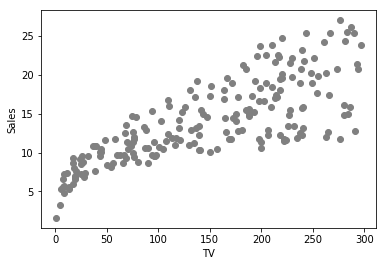

In [4]:
plt.scatter(adv.TV, adv.sales,  color='grey')
plt.xlabel('TV'); plt.ylabel('Sales')
plt.show();

### Split datasets, fit a linear regression and measure $R^2$ over the test set 

As usual, we must start by splitting the dataset into training & test. This time I will do once again to get a validation split. To do so, I will appply the `train_test_split` twice over the training set to get the validation from there.

The idea is to finally evaluate the model using the validation set.

In [5]:
X = pd.DataFrame(adv.TV)
y = pd.DataFrame(adv, columns=['sales'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=25)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=12)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))

Intercept: [7.02261896]
Coefficients: [[0.04686627]]
Mean squared error (MSE): 12.65
Variance score (R2): 0.51


### Interpretation

- The intercept is the expected mean value of the target variable when all predictors are set to 0.
- The coeffient is the slope of the line that explains the regression.
- The R2 is the percentage of explained variance of the predictions.

But, to really see how good is our model, we must evaluate the score ($R^2$) over a validation split --a different split of the data set. We will understand later, why this is important. I'm getting $R^2=0.51$ over this specific test set.

However, if you check the results below, you'll see that the $R^2$ got when predicting over the validation dataset are slightlit better: from $R^2=0.51$ to $R^2=0.64$ !! 

**Why is that?** In this case, for this specific splits, it turns out that the validations split is probably more similar to the training set, than the test set. And that is why our model is better predicting values from that split, than from the test split.

In [6]:
y_generalize = lm.predict(X_val)

print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_val, y_generalize)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_val, y_generalize)))

Intercept: [7.02261896]
Coefficients: [[0.04686627]]
Mean squared error: 11.60
Variance score (R2): 0.64


### Visualization 

Now, plot the original points used to train the linear regression (grey) and the line representing the function that better approximates this relationship between TV and sales that we got from applying the linear regression. 

If you look at the code, you'll see that the way to obtain the values of Y later plotted using `plt.plot` come from directly applying the function describing the linear regression:

$$\hat{y} = \beta_0 + \beta_1 X_{val}$$

Correspondence:
- $\beta_0$ is `lm.intercept_`
- $\beta_1$ is `lm.coef_[0]`

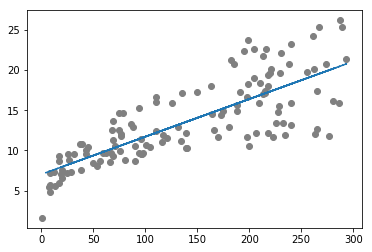

In [7]:
plt.scatter(X_train, y_train, color='gray')
x_vals = X_val.TV.values
y_vals = lm.intercept_ + lm.coef_[0] * x_vals
plt.plot(x_vals, y_vals, '--');

### Cross Validation

As you might possible have figured out, we haven't used the validation dataset, and our model has learnt only from the first (and only) split that we made between training and test. In order to improve our results, a good approach is to repeat the splitting process again and again to obtain the best possible subset of individuals that lead to the best possible model.

To do so, we should repeat the split and validation in a loop to select the best one. Here you can find a possible way of accomplishing that task.

In [8]:
def split_datasets(X, y, seed, 
                   split_test_size=0.2, 
                   validation_split=True):
    """
    Split X and y dataframes into training, test and validation datasets, 
    using the provided random seed.
    Returns a dictionary with the datasets
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=split_test_size, random_state=seed)
    
    split = dict()
    if validation_split is True:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=split_test_size, random_state=seed)
        split['X_val'] = X_val
        split['y_val'] = y_val

    split['X_train'] = X_train
    split['X_test'] = X_test
    split['y_train'] = y_train
    split['y_test'] = y_test

    return split

In [9]:
def prepare_datasets(data, features, target, 
                     seed=1024, 
                     test_size=0.2, 
                     validation_split=False):
    """
    From an input dataframe, separate features from target, and 
    produce splits (with or without validation).
    """
    X = pd.DataFrame(adv, columns=features)
    y = pd.DataFrame(adv.loc[:, target])
    split = split_datasets(X, y, seed=seed, 
                           split_test_size=test_size, 
                           validation_split=validation_split)
    return split

In [10]:
def train_and_predict(X, y, num_folds=1):
    """
    Call the splitting of the dataset, train a linear regression 
    and predict with the test set.
    Returns the model, the splits used and the R2 score.
    """
    lm = linear_model.LinearRegression()
    test_r2 = 0.0
    for i in range(num_folds):
        seed = random.randrange(2**32 - 1)
        split = prepare_datasets(adv, ['TV'], 'sales', 
                                 seed=seed, validation_split=True)

        lm.fit(split['X_train'], split['y_train'])
        y_pred = lm.predict(split['X_test'])
        test_r2 += r2_score(split['y_test'], y_pred)

    test_r2 = test_r2/num_folds
    return lm, split, test_r2

In [11]:
def validate(model, X_val, y_val):
    """
    Scores a model over the validation datasets, by measuring the R2 score.
    Returns the r2.
    """
    y_generalized = lm.predict(X_val)
    r2 = r2_score(y_val, y_generalized)
    return r2

In [12]:
def my_pipeline(X, y, max_iterations, num_folds=1):
    """
    Repeats during `max_iterations` the process of
      1) Splitting a dataset, training a linear regression 
         and measuring its score over test set
      2) Store its R2 and compute its R2 over the validation dataset
    """
    history = dict()
    history['test_r2'] = np.array([])
    history['val_r2'] = np.array([])
    for num_iterations in range(max_iterations):
        model, split, test_r2 = train_and_predict(X, y, num_folds=num_folds)
        val_r2 = validate(model, split['X_val'], split['y_val'])
        history['test_r2'] = np.append(history['test_r2'], test_r2)
        history['val_r2'] = np.append(history['val_r2'], val_r2)
    return history

### Main pipeline call

We are ready now to call the pipeline. The required arguments are the X and y dataframes, and the numner of iterations we want it to run. We can also specify how many runs we want each model to be trained over the same split of training and test, which by default is 1. We will keep it like that for the moment.

It's quite impressive to check how our simple linear regression jumps from a bad 0.64 validation $R^2$ to an impressive $0.84$ ! And only by repeating the shuffling of the training and test sets.

In [13]:
scores = my_pipeline(X, y, max_iterations=100)
max_val_r2 = np.amax(scores['val_r2'])
print('Best Validation R2: {:.2f}'.format(max_val_r2))

Best Validation R2: 0.77


### Visualize Validation Scores

To get an idea of what we got, let's draw a density plot with the validation score values saved along the different iterations. The density plot illustrates how important is to shuffle the training, test and validation sets to find out what is the one which is producing the best generalization.

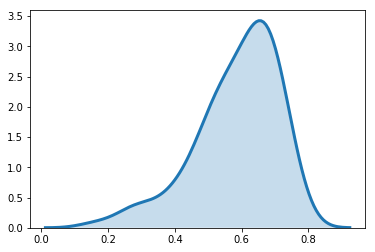

In [14]:
sns.distplot(scores['val_r2'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3});


### Increase the number of folds in train and test

What if I increase the number of folds from 1 to 10? The results are plotted below and there's n significant improvement in the results of the validation scores. 

Why? Well, It's namely because of the way we implemented our train & predict method: we're training `num_folds` linear regression without keeping it for test scoring. If we do that, we will explore which model will better generalize over different test sets, but keeping a single training split. And that will for sure, be a better method to assess over the the validation split.

**Important**

By partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets. 

A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets.

Best Validation R2: 0.79


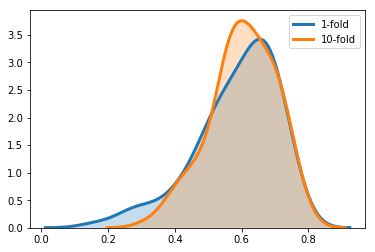

In [15]:
score_2 = my_pipeline(X, y, max_iterations=100, num_folds=10)
max_val_r2 = np.amax(score_2['val_r2'])
print('Best Validation R2: {:.2f}'.format(max_val_r2))

fig, ax = plt.subplots()
sns.distplot(scores['val_r2'], hist = False, kde = True,
             label='1-fold',
             kde_kws = {'shade': True, 'linewidth': 3}, ax=ax);
sns.distplot(score_2['val_r2'], hist = False, kde = True,
             label='10-fold',
             kde_kws = {'shade': True, 'linewidth': 3}, ax=ax);
plt.legend(loc='best')
plt.show();

## Using SKLEARN Pipelines

Instead of having you to program everything from scratch, you can also access `sklearn` API for building preprocessing and cross validation pipelines. In the example below, we put in practice the very same approach used before, but using only three lines of code (!).

I strongly recommend you to explore deeper the capabilities of the cross validation functions in SKLearn.

## Features preprocessing

Before we go deeper, we must ensure that our features fulfill the set of requirements that are imposed by the linear regression method: centered and with variance = 1, following a normal ditribution and no correlation among them, namely. To do so, we will build a transformation pipeline. For more details, please, refere to the page: https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

This case we're using the sklearn-pandas integration library `sklearn_pandas` which makes transformation pipelines much easier to read and understand. In the example below we're simply applying a standard scaler.

In [16]:
mapper = DataFrameMapper([(list(adv), StandardScaler())], df_out=True)
res = np.round(mapper.fit_transform(adv), 2)
res.columns = list(adv)  # Set the columns names as they were.

### Simple Cross Validation score

As we said, instead of having to program every single function in charge of splitting the datasets, setting the random seed, feeding a model with the training part and evaluating with test part, we will explore the `cross_val_score` method. It will be able to produce a single scoring (if you want more than one, you must use `cross_validate`) and will allow you to decide what CV strategy to use, or build a custom one.

In the example below, we feed the `cross_val_score` with 
- the model (or pipeline) to be fit (`model`), 
- the features (`X`),
- the target datasets (`y`), 
- the cross validation strategy (`cv`), and
- the validation metric we want as a result (`r2`)

This will run the cross validation with the model over the features and target using a ShuffleSplit (similar to _k-fold_ but with random splits), _n_splits_ (1000) times, evaluating with a 20% split as a test set, and returning the R2 achieved.

Best Validation R2: 0.76


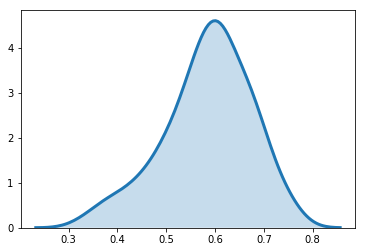

In [17]:
model = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=666)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print('Best Validation R2: {:.2f}'.format(max(scores)))

sns.distplot(scores, hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3});

## Multiple Linear Regression

We want to consider all possible predictors available when it comes to train model. So, it's time to use the other two columns in the original dataset: radio and newspapers.

In [18]:
X = pd.DataFrame(adv.loc[:, ['TV','radio','newspaper']])
y = pd.DataFrame(adv, columns=['sales'])
X.head(2)

,TV,radio,newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1


To train a multiple linear regression, the only thing that we must do is to feed the model with all the variables that you want to consider for the final equation. Obviously, building a linear model with 3 features, implies that our model is better described in 3+1 dimensions, which makes this task slightly more difficult to plot.

In [19]:
mlm, split, test_r2 = train_and_predict(X, y)
print('Multiple linear regression R2: {:.2f}'.format(test_r2))
print('Multiple linear regression coeffcients: {}'.format(mlm.coef_))

Multiple linear regression R2: 0.65
Multiple linear regression coeffcients: [[0.04843507]]


Repeating our CV experiment with SKLearn, this time replacing the single-feature $X$ by a 3-features dataframe $X$, leads to a similar result ($0.96$).

Best Validation R2: 0.95


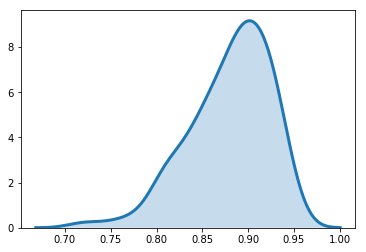

In [20]:
clf = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv, scoring='r2')
print('Best Validation R2: {:.2f}'.format(max(scores)))

sns.distplot(scores, hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3});

### What's important in Multiple linear regression

There's two concepts that are important when running a multiple linear regression: _p_values_ and the R-squared. Take a look to the values below in order to understand if this multiple linear regression is a better approximation to the original problem than the single-predictor linear regression.

In [21]:
X = add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 28 Dec 2018   Prob (F-statistic):           1.58e-96
Time:                        11:42:52   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

## Bias and variance over training

One of the advantages of linear regression is that we can make it as much complicated or fitted to data as we want. We simply add polynomial interactions between variables the following way:

- Split datasets to hold out a test set, and use the training set for a cross-validation model selection
- Build an sklearn _pipeline_ to randomly produce polynomial expressions before fitting a linear regression
- Perform a CV validation score over the test set to check how do the models perform.

We will extract some parts of the code to separate functions for the sake of code clarity, and better readibility. The first function (`xy_values`) will simply produce a dataframe with columns `x` and `y` after applying the prediction stage to an input dataframe. The second function (`polynomial_pipeline`) will construct a pipeline in which at first, a polynomial is found over input dataset, and second, a linear regression is fit (OLS) with that polynomial.

In [22]:
def xy_values(pipeline, X):
    """ Returns the x and y values sorted by X in a dataframe """
    y_pred = pipeline.predict(X)
    return pd.DataFrame({'x': list(X.values), 'y': list(y_pred)}).\
                        sort_values(by=['x'])

In [23]:
def polynomial_pipeline(X, y, degree):
    """
    Build a pipeline with polinomial expressions and linear regression over it.
    """
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=555)
    poly = PolynomialFeatures(degree=degree, interaction_only=False, 
                              include_bias=False)
    lm = linear_model.LinearRegression()
    pipeline = make_pipeline(poly, lm)
    pipeline.fit(X, y)
    return pipeline

In [24]:
split = prepare_datasets(adv, ['TV'], 'sales')
pipeline = polynomial_pipeline(split['X_train'], split['y_train'], degree=2)
scores = cross_val_score(pipeline, split['X_test'], split['y_test'],
                         scoring="r2", cv=cv)
print('The polynomial features used are:\n', 
      pipeline.get_params('polynomialfeatures')['polynomialfeatures'].\
      get_feature_names())
print('Best Validation R2: {:.2f}'.format(max(scores)))

The polynomial features used are:
 ['x0', 'x0^2']
Best Validation R2: 0.78


### Plot the polynomial expression.

As you can easily check for this simulation, the higher degree polynomial means a better fit to the training but poorer generalization. It seems that here we might be overfitting a bit.

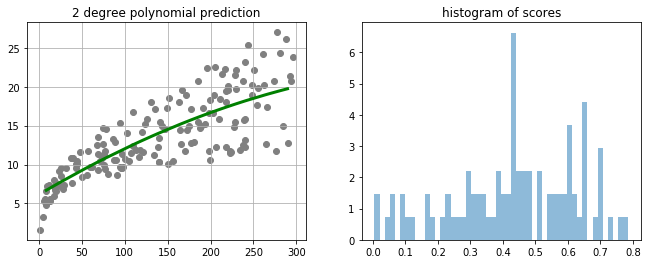

In [25]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
f.set_figwidth(11)
ax1.scatter(split['X_train'].values, split['y_train'].values, color='grey')

pred = xy_values(pipeline, split['X_test'])
ax1.plot(pred.x.values, pred.y.values, label='prediction',
         linewidth=3, color='green')
ax1.grid()
ax1.set_title('2 degree polynomial prediction')

ax2.hist(scores[scores>0], 50, normed=1, alpha=0.5);
ax2.set_title('histogram of scores')
plt.show();

### Training size effect

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

A cross-validation generator splits the whole dataset $k$ times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the **scores will be averaged** over all $k$ runs for each training subset size.

Can you interpret what is the number of samples you need to feed your model in training, in order to get the best possible result? When adding more samples does not add significant advantage?

In [26]:
def plot_training_curve():
    plt.plot(train_sizes, np.mean(train_scores, axis=1), '-o',
             label='train_scores')
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), '-o',
             label='validation_scores')
    plt.title('Training curve')
    plt.legend(loc='best')
    plt.xlabel('Training set size')
    plt.ylabel('Explained variance ($R^2$)')
    plt.grid()
    plt.show()

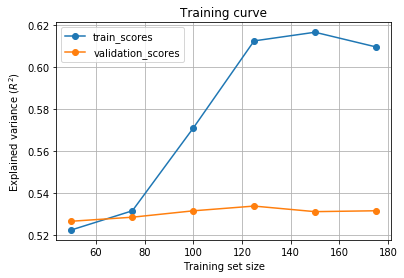

In [27]:
split = prepare_datasets(data=adv, features=['TV'], target='sales', test_size=0.0)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=666)
train_sizes, train_scores, valid_scores = learning_curve(
    lm, split['X_train'], split['y_train'], 
    train_sizes=[50, 75, 100, 125, 150, 175], 
    cv=10)
plot_training_curve()

### What about the degree of the polynomial?

Let's work on the `sklearn.model_selection.validation_curve` to see how the degree of the polynomial affects the R2 score. We pass an array of possible degrees for the polynomials to the `validation_curve` method.

Compute scores for an estimator with different values of a specified parameter (degree of polynomial). This is similar to grid search with one parameter. However, this will also compute training scores and is merely a utility for plotting the results.

In [28]:
def plot_validation_curve():
    # Plot the mean train error and validation error across folds
    plt.figure(figsize=(6, 4))
    plt.plot(degrees, train_scores.mean(axis=1), '-o',
             lw=2, label='training')
    plt.plot(degrees, validation_scores.mean(axis=1), '-o',
             lw=2, label='cross-validation')
    plt.title('Validation curve')
    plt.legend(loc='best')
    plt.xlabel('degree of polynomial')
    plt.ylabel('explained variance ($R^2$)')
    plt.tight_layout()
    plt.grid()
    plt.show()

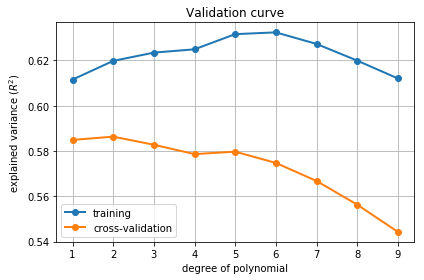

In [29]:
split = prepare_datasets(data=adv, features=['TV'], target='sales', test_size=0.0)
lm = linear_model.LinearRegression()
degrees = np.arange(1, 10)
model = make_pipeline(PolynomialFeatures(), lm)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=666)

train_scores, validation_scores = validation_curve(
                 model, split['X_train'], split['y_train'],
                 param_name='polynomialfeatures__degree',
                 cv=cv,
                 param_range=degrees)
plot_validation_curve()

It seems that increasing the degree of the polynomial beyond '2' produces a decrease in validation accuracy.

Now try to iterate over different maximum degrees for the polinomials to be generated to see how they affect the overall score of the model.

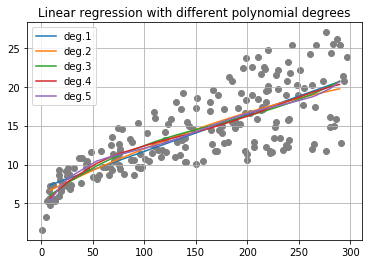

In [30]:
plt.figure(figsize=(6, 4))
plt.scatter(split['X_train'].values, split['y_train'].values, color='grey')

split = prepare_datasets(adv, ['TV'], 'sales', seed=1024)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=666)

for degree in range(1, 6):
    pipeline = polynomial_pipeline(split['X_train'], split['y_train'], degree)
    scores = cross_val_score(pipeline, split['X_test'], split['y_test'],
                             scoring="r2", cv=10)
    pred = xy_values(pipeline, split['X_test'])
    plt.plot(pred.x.values, pred.y.values, 
             label='deg.{}'.format(degree))
    
plt.title('Linear regression with different polynomial degrees')
plt.legend(loc='best')
plt.grid()
plt.show()